In [1]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import itertools

In [4]:
filename = 'data/images/eye.jpg'

In [5]:
class PixelProcessor:
    def __init__(self, filepath:str):
        self.img = np.asarray(Image.open(filepath))

    def get_grey_image(self):
        return np.apply_along_axis(self._pixel2gray, -1, self.img)

    def get_grey_image2(self):
        return np.apply_along_axis(self._pixel2gray2, -1, self.img)

    def get_negate(self):
        return 255 - self.img 
    
    def get_brightness(self, brightness):
        brightened =  self.img + brightness
        brightened[brightened < 0] = 0
        brightened[brightened > 255] = 255
        return brightened
    
    def get_contrast(self, contrast: float):
        # http://www.dfstudios.co.uk/articles/programming/image-programming-algorithms/image-processing-algorithms-part-5-contrast-adjustment/
        F = (259 * (contrast + 255)) / (255 * (259 - contrast))
        return np.apply_along_axis(self._contrast_pixel, -1, self.img, F)

    def get_global_thresholding_simple(self, threshold):
        # http://www.cse.iitd.ernet.in/~pkalra/col783/Thresholding.pdf
        img = self.get_grey_image()
        return np.apply_along_axis(self._threshold, -1, img, threshold)

    def get_histogram(self):
        # TODO Histogram equalization
        unique, counts = np.unique(self.img, return_counts=True)
        plt.figure(figsize=(20, 10))
        plt.bar(unique, counts)

    def get_image_projection_row_wise(self, threshold):
        # Transform to binary image
        img = self.get_global_thresholding_simple(threshold)
        height, width, _ = img.shape
        row_projection = [sum(r for r, g, b in row)//3 for row in img]
        ran = list(range(height))
        plt.figure(figsize=(20, 10))
        plt.gca().invert_yaxis()
        plt.barh(ran, row_projection)

    def get_image_projection_column_wise(self, threshold):
        img = self.get_global_thresholding_simple(threshold)
        column_grey_img = np.transpose(img, (1, 0, 2))
        width, height, _ = column_grey_img.shape
        column_projection = [sum(r for r, g, b in column)//3 for column in column_grey_img]
        ran = list(range(width))
        plt.figure(figsize=(20, 10))
        plt.bar(ran, column_projection)

    def convolution(self, filter: list):
        filter = np.array(filter)
        height, width = filter.shape
        filter = filter.flatten()
        img = self.img
        new_image = []
        print(f'Applying filter {filter}')
        for index, rows in enumerate(zip(*[img[i:] for i in range(height)])):
            new_image.append([])
            row1,row2,row3 = rows
#             for frame in zip(list(itertools.chain(row[i:] for i in range(width))) for row in rows):
            for frame in zip(row1[0:], row1[1:], row1[2:], row2[0:], row2[1:], row2[2:], row3[0:], row3[1:], row3[2:]):
                frame = np.array(frame)
                r, g, b = [frame[:, i] for i in range(3)]
                new_pixel = np.dot([r, g, b], filter).astype(np.uint8)
                new_image[index].append(new_pixel)
        return np.array(new_image)

    @staticmethod
    def _pixel2gray(pixel):
        grey = float(sum(pixel) // 3)  # Average of 3 colors
        return [grey] * len(pixel)

    @staticmethod
    def _pixel2gray2(pixel):
        scale = [0.2126, 0.7152, 0.0722]  # factor to grayscale
        return [val * scal for val, scal in zip(pixel, scale)]

    @staticmethod
    def _contrast_pixel(pixel, factor):
        return [factor * (color - 128) + 128 for color in pixel]

    @staticmethod
    def _threshold(pixel, threshold):
        return [1. if color > threshold else 0. for color in pixel]
pixel_processor = PixelProcessor(filename)

In [6]:
class Filters:
    @staticmethod
    def low_pass(a :int):
        return [[1,1,1],[1,a,1],[1,1,1]]
    @staticmethod
    def gaussian(b:int):
        return [[1,b,1],[b,b**2,b],[1,b,1]]
    @staticmethod
    def laplacian():
        return [[0,-1,0],[-1,4,-1],[0,-1,0]]
    @staticmethod
    def derivatives_on_the_diagonals():
        return [[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]
    @staticmethod
    def derivatives_for_three_parallel_lines_in_vertical_and_horizontal():
        return [[-2,1,-2],[1,4,1],[-2,1,-2]]
    @staticmethod
    def identity():
        return [[0,0,0],[0,1,0],[0,0,0]]
    @staticmethod
    def sharpen():
        return [[0,-1,0],[-1,5,-1],[0,-1,0]]

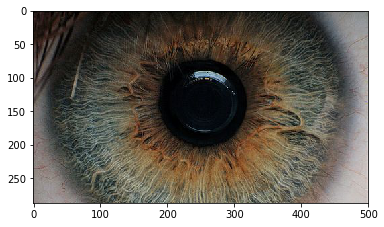

In [7]:
imshow(pixel_processor.img)

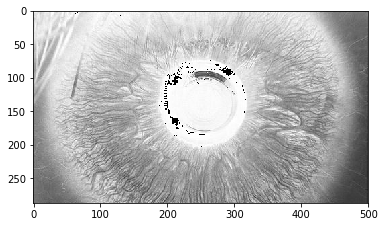

In [8]:
gray = pixel_processor.get_grey_image()
imshow(gray)

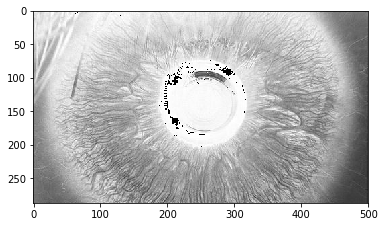

In [9]:
gray2 = pixel_processor.get_grey_image2()
imshow(gray)

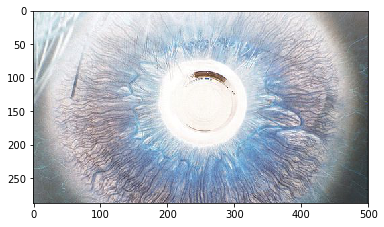

In [10]:
imshow(pixel_processor.get_negate())

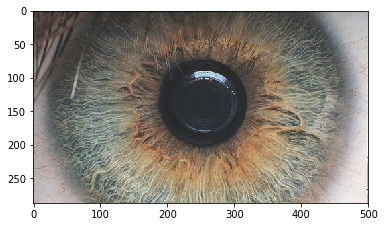

In [11]:
imshow(pixel_processor.get_brightness(40))

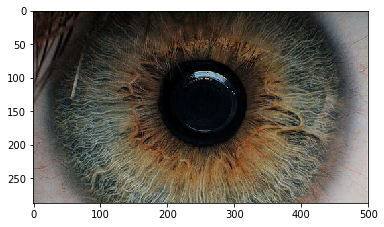

In [12]:
imshow(pixel_processor.get_contrast(1.006))

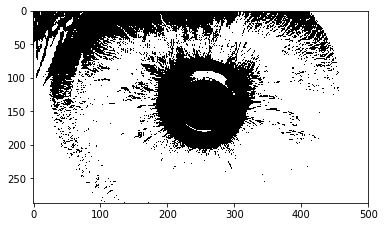

In [13]:
imshow(pixel_processor.get_global_thresholding_simple(40))

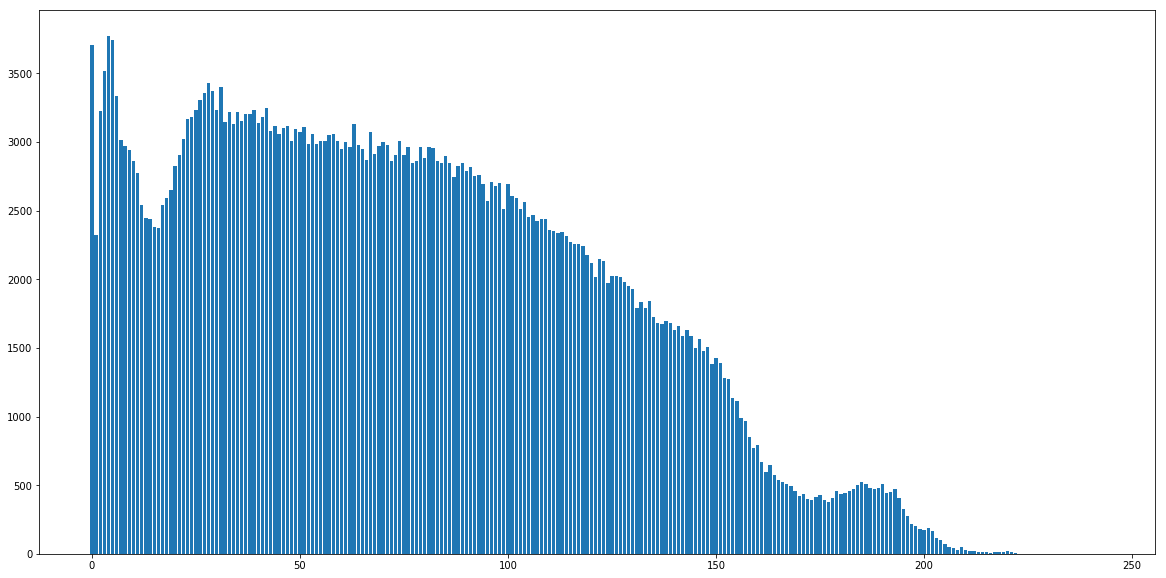

In [14]:
pixel_processor.get_histogram()

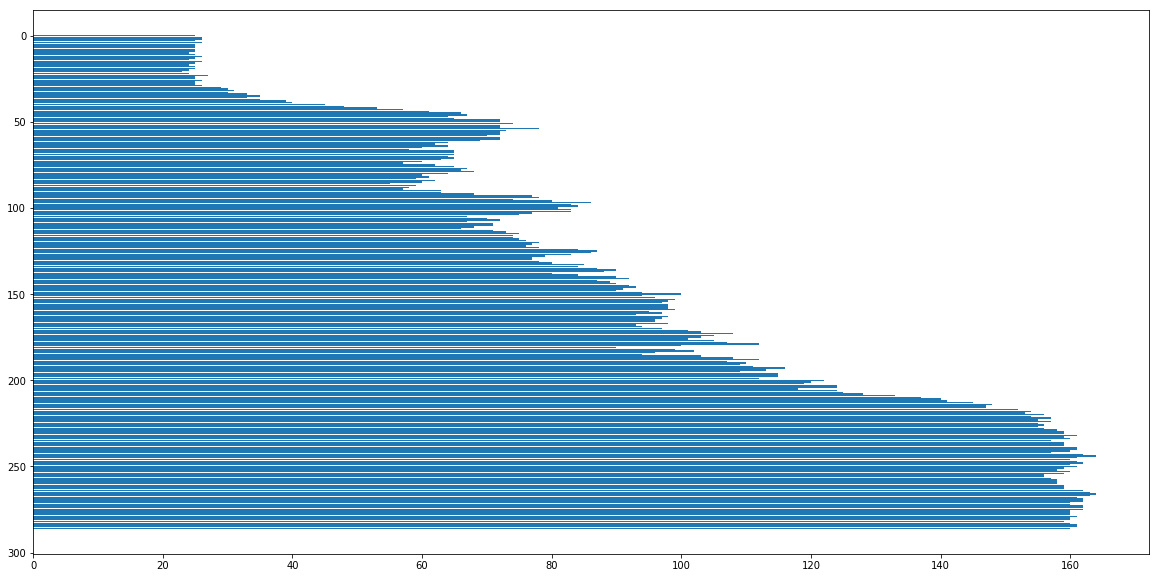

In [15]:
pixel_processor.get_image_projection_row_wise(60)

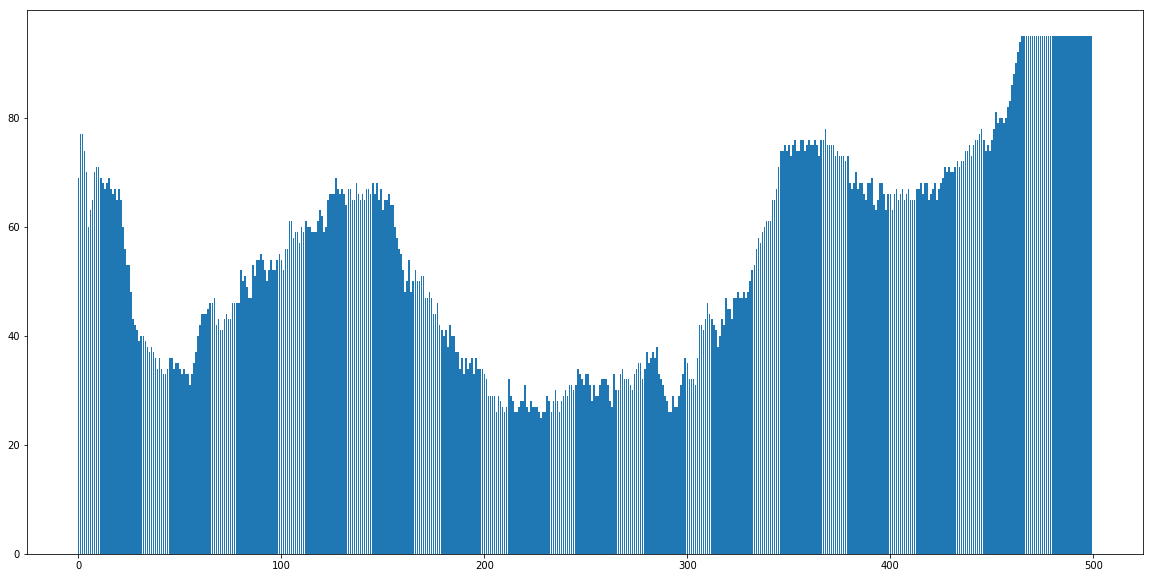

In [16]:
pixel_processor.get_image_projection_column_wise(60)

Applying filter [0 0 0 0 1 0 0 0 0]
Origin shape (287, 500, 3) --> New shape (285, 498, 3)


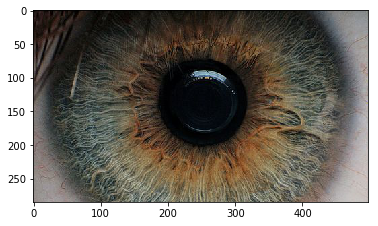

In [17]:
new_image = (pixel_processor.convolution(Filters.identity()))
imshow(new_image)
print(f'Origin shape {pixel_processor.img.shape} --> New shape {new_image.shape}')